In [1]:
# Importação das bibliotecas básicas
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
#from google.colab import drive

# Aparência dos gráficos
from jupyterthemes import jtplot
jtplot.style(theme='chesterish') # onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd

# Importação das bibliotecas necessáris do Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

In [2]:
TOKEN = 'TOKEN DE SUA CONTA IBM QUANTUM'
IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

configrc.store_credentials:WARNING:2021-12-04 01:43:50,451: Credentials already present. Set overwrite=True to overwrite.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [3]:
# Escolhe apenas os backends de 5 qubits e não são simuladores
backends_5qubits = provider.backends(filters=lambda x: x.configuration().n_qubits == 5
                                             and not x.configuration().simulator
                                             and not x.name() == 'ibmq_santiago' #em manutenção
                                             and x.status().operational==True)
backends_5qubits

[<IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [4]:
# Cria uma lista com apenas os nomes dos backends de 5qubits
names_backends_5qubits = []
for i in range(len(backends_5qubits)):
    names_backends_5qubits.append(backends_5qubits[i].name())
names_backends_5qubits

['ibmq_bogota', 'ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila']

In [5]:
def SC(qc, q1,q2):
    """Esta função recebe um circuito previamente criado qc e realiza emaranhamento entre os qubits 
    indicados nos parâmetros q1 e q2 da função"""
    qc.h(q1)
    qc.cx(q1,q2)
    qc.barrier()
    qc.x(q2)
    qc.z(q2)
    qc.barrier()
    qc.cx(q1,q2)
    qc.h(q1)
    qc.barrier()
    qc.measure([q1, q2], [0, 1])
    return qc

In [6]:
# Criação de uma lista com os circuitos com as permutações de emaranhamento
circuitos = []
circuitos.clear()
for i in range(4):
    circuitos.append(SC(QuantumCircuit(5,2),0,i+1))

In [7]:
# Função que cria uma lista de ciruitos transpilados para um dado backend.
# Essa dependência com o backend se deve justamente a arquitetura do chip na hora de transpilar.
def transpilados(circuitos, processador):
    """Esta função recebe uma lista de circuitos e um backend e devolve uma lista de 
    circuitos transpilados"""
    transpilado = []
    for circuito in circuitos:
        transpilado.append(transpile(circuito, processador))
    return transpilado

In [8]:
# Em certos casos podem existir 2 circuitos transpilado para dado circuito ideal.
# Em chips lineares o circuito[1] e o circuito[3] podem retornar, cada, 2 circuitos transpilado.
# Em chips com formato de T o circuito[2] pode retornar 2 circuitos transpilado.

In [9]:
# Cria uma lista padronizada de circuitos transpilados para cada arquitetura de chip
circuitosL = transpilados(circuitos, provider.get_backend('ibmq_manila'))
circuitosT = transpilados(circuitos, provider.get_backend('ibmq_lima'))

In [10]:
# Cria um modelo de Noise baseado em um backend da IBMQ
# ['ibmq_santiago', 'ibmq_bogota', 'ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila']
backendNoise = provider.get_backend('ibmq_bogota')

noise_model = NoiseModel.from_backend(backendNoise)
coupling_map = backendNoise.configuration().coupling_map
basis_gates = noise_model.basis_gates
backend_properties = backendNoise.properties()

# Define o simulador QASM (capaz de simular Noise)
simulador=Aer.get_backend('qasm_simulator')

In [11]:
# Função que recebe um backend (simulador), um circuito (transpilado ou não), um número n de jobs que serão simulados,
# o número de shots, e 4 parâmetros de Noise que irão simular o comportamento de um backend real.
# Retorna uma lista de listas, com a porcentagem do resultado de cada uma das medições ('00', '01', '10', '11').
def medidas(backend, circuito, n, shots=8192, basis_gates=basis_gates, 
            coupling_map=coupling_map, noise_model=noise_model, backend_properties=backend_properties):
    """A função recebe um backend e um circuito. 'n' representa o número de job's que você fará no backend 
    e 'shots' é o numero de repeticoes de cada circuito."""
    medidas=[]
    for _ in range(n):
        job=execute(circuito, backend, shots=shots, 
                    basis_gates=basis_gates, 
                    coupling_map=coupling_map, 
                    noise_model=noise_model,
                    backend_properties=backend_properties).result()
        counts = job.get_counts()
        
        # Transforma {'11': 8192} em:
        # {'00': 0, '01': 0, '10': 0, '11': 8192}
        comb = ['00', '01', '10', '11']
        for key in comb:
            if key not in counts.keys():
                counts[key] = 0
        
        # Transforma {'01': 432, '11': 6918, '10': 779, '00': 63} em:
        # {'00': 63, '01': 432, '10': 779, '11': 6918}
        countsOrdenado = dict(sorted(counts.items(), key=lambda x: x[0].lower()))
        medidas.append(countsOrdenado)
    
    # Transforma {'00': 81, '01': 433, '10': 826, '11': 6852} em:
    # [81, 433, 826, 6852]
    medidasLista=[]    
    for y in range(len(medidas)):
        medidasLista.append(list(medidas[y].values()))
    return np.array(medidasLista)/shots*100

In [12]:
# Exemplo de simulação que utiliza os parâmetros de Noise definidos a duas celulas acima
medidas(simulador, circuitosL[0], 10, shots=8192, basis_gates=basis_gates, 
            coupling_map=coupling_map, noise_model=noise_model, backend_properties=backend_properties)

array([[ 0.86669922,  6.53076172,  3.83300781, 88.76953125],
       [ 0.61035156,  6.45751953,  3.34472656, 89.58740234],
       [ 0.73242188,  6.56738281,  3.56445312, 89.13574219],
       [ 0.5859375 ,  6.49414062,  3.96728516, 88.95263672],
       [ 0.75683594,  6.40869141,  3.85742188, 88.97705078],
       [ 0.74462891,  6.18896484,  3.44238281, 89.62402344],
       [ 0.68359375,  6.39648438,  3.99169922, 88.92822266],
       [ 0.54931641,  6.29882812,  3.79638672, 89.35546875],
       [ 0.74462891,  6.29882812,  3.44238281, 89.51416016],
       [ 0.72021484,  6.45751953,  3.72314453, 89.09912109]])

In [13]:
# Recebe o nome de um backend da IBMQ em formato de string e retorna os 4 parâmetros de Noise
def atualizarSimulador(backend):
    backendNoise = provider.get_backend(backend)
    noise_model = NoiseModel.from_backend(backendNoise)
    coupling_map = backendNoise.configuration().coupling_map
    basis_gates = noise_model.basis_gates
    backend_properties = backendNoise.properties()

    return noise_model, coupling_map, basis_gates, backend_properties

In [14]:
# Função que recebe o nome de um backend da IBMQ em formato de string, um número n de jobs,
# o número de shots, e retorna um DataFrame pandas.
def gerarDataframe(backend, n, shots=8192):
    simulador = Aer.get_backend('qasm_simulator')
    noise_model, coupling_map, basis_gates, backend_properties = atualizarSimulador(backend)

    if backend=='ibmq_bogota' or backend=='ibmq_manila' or backend=='ibmq_santiago':
        circuito = circuitosL
    elif backend=='ibmq_lima' or backend=='ibmq_belem' or backend=='ibmq_quito':
        circuito = circuitosT

    for x in range(4):
        globals()[f'dados{x}_{backend}'] = {}
        globals()[f'medidas{x}_{backend}'] = medidas(simulador, circuito[x], n, shots=shots, basis_gates=basis_gates, 
                                                    coupling_map=coupling_map, noise_model=noise_model, 
                                                    backend_properties=backend_properties)

        for i in range(len(globals()[f'medidas{x}_{backend}'])):
            globals()[f'dados{x}_{backend}'].update({f'rodada {i+1}': globals()[f'medidas{x}_{backend}'][i]})
        globals()[f'circuito{x}'] = pd.DataFrame(globals()[f'dados{x}_{backend}'], index=['00', '01', '10', '11'])

    dataframe = pd.concat([circuito0.transpose(), circuito1.transpose(), circuito2.transpose(), circuito3.transpose()], 
                          keys={'Circuito 1' : circuito0, 'Circuito 2' : circuito1, 
                                'Circuito 3' : circuito2, 'Circuito 4' : circuito3})
    return dataframe

In [15]:
# Exemplo de DataFrame gerado simulando o Noise do backend 'ibmq_manila'.
# Observe o parâmetro .transpose() no final do código.
gerarDataframe(backend='ibmq_manila', n=3, shots=8192).transpose()

Circuito 1                       Circuito 2                        \
     rodada 1   rodada 2   rodada 3   rodada 1   rodada 2   rodada 3   
00   0.524902   0.500488   0.292969   0.354004   0.390625   0.537109   
01   3.857422   4.125977   4.321289   4.394531   4.467773   4.040527   
10   2.941895   3.381348   3.234863   5.761719   5.810547   5.810547   
11  92.675781  91.992188  92.150879  89.489746  89.331055  89.611816   

   Circuito 3                       Circuito 4                        
     rodada 1   rodada 2   rodada 3   rodada 1   rodada 2   rodada 3  
00   0.476074   0.451660   0.427246   0.512695   0.354004   0.415039  
01   4.504395   4.492188   4.235840   4.565430   5.004883   4.760742  
10   6.042480   5.444336   5.444336   5.786133   5.639648   5.664062  
11  88.977051  89.611816  89.892578  89.135742  89.001465  89.160156

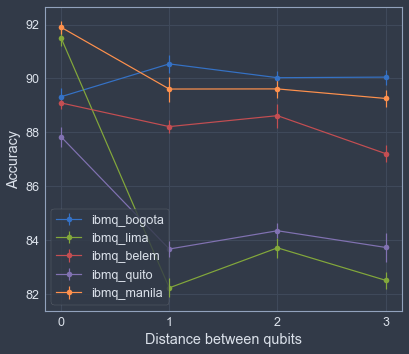

In [16]:
#Cria um gráfico de linhas baseado na acurácia do resultado de cada um dos 4 circuitos.
#Criará um gráfico para cada backend dentro da lista 'names_backends_5qubits'. Retorna uma imagem com os 6 gráficos.
#OBS: names_backends_5qubits = ['ibmq_santiago', 'ibmq_bogota', 'ibmq_lima', 'ibmq_belem', 'ibmq_quito', 'ibmq_manila'].
dados_conect = [0,1,2,3]
for backend in names_backends_5qubits:
    globals()[f'dataframe_{backend}'] = gerarDataframe(backend=backend, n=10, shots=8192)
    
    globals()[f'dados_plot_{backend}'] = [
    globals()[f'dataframe_{backend}'].loc[f'Circuito {x+1}'].mean()[3] 
    for x in range(4)]
    
    globals()[f'dados_std_{backend}'] = [
    globals()[f'dataframe_{backend}'].loc[f'Circuito {x+1}'].std()[3]
    for x in range(4)]
    
    globals()[f'grafico_{backend}'] = plt.errorbar(dados_conect, globals()[f'dados_plot_{backend}'], 
    yerr=globals()[f'dados_std_{backend}'], fmt='o-', label=f'{backend}')
    
plt.xticks(dados_conect)
plt.xlabel('Distance between qubits')
plt.ylabel('Accuracy');
plt.legend(loc='lower left') # upper left, upper right, lower left, lower right
plt.savefig('plot.pdf', format='pdf') # salva a imagem em um arquivo pdf

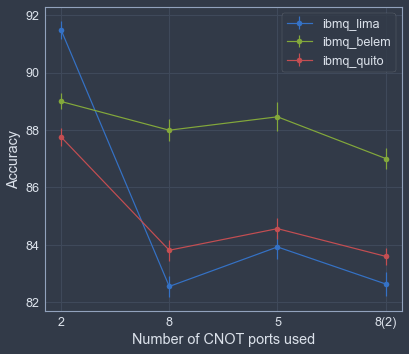

In [17]:
# Cria um gráfico para cada arquitetura de chip escolhida
arquiteturaL = ['ibmq_bogota', 'ibmq_manila']
arquiteturaT = ['ibmq_lima', 'ibmq_belem', 'ibmq_quito']
dados_conect = ["2","8","5","8(2)"]
for backend in arquiteturaT: #escolha entre arquiteturaL e arquiteturaT 
    globals()[f'dataframe_{backend}'] = gerarDataframe(backend=backend, n=10, shots=8192)
    
    globals()[f'dados_plot_{backend}'] = [
    globals()[f'dataframe_{backend}'].loc[f'Circuito {x+1}'].mean()[3] 
    for x in range(4)]
    
    globals()[f'dados_std_{backend}'] = [
    globals()[f'dataframe_{backend}'].loc[f'Circuito {x+1}'].std()[3]
    for x in range(4)]
    
    globals()[f'grafico_{backend}'] = plt.errorbar(dados_conect, globals()[f'dados_plot_{backend}'], 
    yerr=globals()[f'dados_std_{backend}'], fmt='o-', label=f'{backend}')
    
plt.xticks(dados_conect)
plt.xlabel('Number of CNOT ports used')
plt.ylabel('Accuracy');
plt.legend(loc='upper right')
plt.savefig('plot2.pdf', format='pdf')

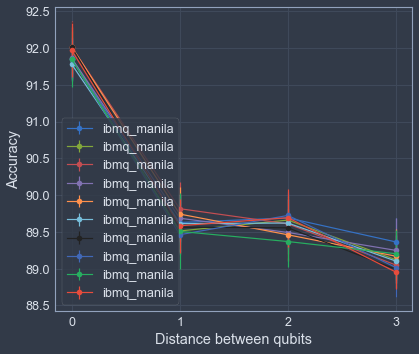

In [18]:
# Roda o mesmo backend 10x e monta um gráfico. Útil para detectar grandes variações em um mesmo backend.
teste_backends_5qubits = ['ibmq_manila'] *10
dados_conect = [0,1,2,3]
for backend in teste_backends_5qubits:
    globals()[f'dataframe_{backend}'] = gerarDataframe(backend=backend, n=10, shots=8192)
    
    globals()[f'dados_plot_{backend}'] = [
    globals()[f'dataframe_{backend}'].loc[f'Circuito {x+1}'].mean()[3] 
    for x in range(4)]
    
    globals()[f'dados_std_{backend}'] = [
    globals()[f'dataframe_{backend}'].loc[f'Circuito {x+1}'].std()[3]
    for x in range(4)]
    
    globals()[f'grafico_{backend}'] = plt.errorbar(dados_conect, globals()[f'dados_plot_{backend}'], 
    yerr=globals()[f'dados_std_{backend}'], fmt='o-', label=f'{backend}')
    
plt.xticks(dados_conect)
plt.xlabel('Distance between qubits')
plt.ylabel('Accuracy');
plt.legend(loc='lower left')
plt.savefig(f'{backend}.pdf', format='pdf')